# <font color="#5fa8d3"> Creating the dataset


## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation & Funtions Definition](#id0)<br>
1. [Anlysis of data](#id1)<br>
    1.1 [Example](#id11)<br>
2. [Train set](#id2)<br>
    2.1 [Coco format](#id21)<br>
    2.2 [Breaking down a damage category by severity](#id22)<br>
    2.3 [Change classes' id](#id23)<br>
    2.4 [Split in train and validation sets](#id24)<br>
3. [Test](#id3)<br>
    3.3 [Read test set](#id31)<br>
    3.2 [Coco format](#id32)<br>
    3.3 [Breaking down a damage category by severity](#id33)<br>
    3.4 [Change classes' id](#id34)<br>
    3.5 [Test folder](#id35)<br>

## <font color="#62b6cb"> 0. Libraries Importation, Parameters & Funtions Definition <a name="id0"></a>

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
from IPython.display import clear_output, display
import datetime
import random
import shutil
import ipywidgets as widgets
import yaml # for importing a yaml file
from src.mymodule import * # for importing our functions

**Configuration Variables**

In [87]:
# Load the YAML file
with open('..\config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Function to set variables globally and store their names
def set_variables(config, prefix='', var_dict={}):
    for key, value in config.items():
        if isinstance(value, dict):
            set_variables(value, prefix + key + '_', var_dict)
        else:
            globals()[prefix + key] = value
            var_dict[prefix + key] = value
    return var_dict

# Set variables globally and get a dictionary of the set variables
set_vars = set_variables(config)

# Print all the variables that were set
print("Variables set from YAML file:")
for var_name, var_value in set_vars.items():
    print(f"{var_name}: {var_value}")

Variables set from YAML file:
seed: 123


In [88]:
# PARAMETERS
# paths
kaggle_json_train  = "./archive/train.json"
kaggle_json_val = "./archive/val.json"
image_path = ".\\archive\\image\\image\\01012020_172204image853193.jpg"
train_path_original = ".\\archive\\image\\image"
test_path_original = ".\\archive\\validation\\validation"
train_annotations_json = "annotations.json"
val_annotations_json = "annotations.json"
test_annotations_json = "annotations.json"
output_json_severity_path = ".\\archive\\image\\annotation_severity.json"
output_json_severity_path_test = ".\\archive\\validation\\annotation_severity.json"
temp_state_path = ".\\archive\\image\\temp_state.json"
temp_state_path_test = ".\\archive\\validation\\temp_state.json"
path_split = ".\\CustomImages\\" # folder with sets of train, val and test
folder_train_split = "train"
folder_val_split = "val"
folder_test_split = "test"
folder_old_annnotations_train = "old_json_train"
folder_old_annnotations_test = "old_json_test"

# class name 
class_name = "met_dent"

# class break down dented
dented_severity_apply_train = 0
dented_severity_apply_test = 0

# Porcentaje de división
val_percentage = 0.2

# replace the classes
mapping = {
    "mat_bo_phan": "mis_lost",
    "rach": "met_tear",
    "mop_lom": "met_dent",
    "tray_son": "met_scratch",
    "thung": "mis_punct",
    "vo_kinh": "glass_crack",
    "be_den": "mis_lamp"
}

# Dictionary for converting the classes id
old_to_new_ids = {
    1: 1,
    2: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
    8: 7,
    9: 8,
    10: 9
}

# Update the categories
new_categories = [
    {'id': 1, 'name': 'mis_lost', 'supercategory': 'car_damage'},
    {'id': 2, 'name': 'met_tear', 'supercategory': 'car_damage'},
    {'id': 3, 'name': 'met_scratch', 'supercategory': 'car_damage'},
    {'id': 4, 'name': 'glass_crack', 'supercategory': 'car_damage'},
    {'id': 5, 'name': 'mis_punct', 'supercategory': 'car_damage'},
    {'id': 6, 'name': 'mis_lamp', 'supercategory': 'car_damage'},
    {'id': 7, 'name': 'met_dent_minor', 'supercategory': 'met_dent'},
    {'id': 8, 'name': 'met_dent_medium', 'supercategory': 'met_dent'},
    {'id': 9, 'name': 'met_dent_severe', 'supercategory': 'met_dent'}
]

## <font color="#62b6cb"> 1. Analysis of data <a name="id1"></a>



The train json of Kaggle is read

In [89]:
# Read the JSON file
with open( kaggle_json_train, "r") as file:
    data = json.load(file)

# Prepare the list to store the extracted information
data_list = []

# keys of data are the name of images
# Extract information from the JSON data

for image_name, image_info in data.items():
    for region in image_info["regions"]:
        region_data = {
            "name": image_name,
            "all_x": region["all_x"],
            "all_y": region["all_y"],
            "class": region["class"]
        }
        data_list.append(region_data)

# Create a DataFrame from the extracted information
df = pd.DataFrame(data_list)

the keys of data are the name of the images. Each name of the image has a dict associated with the name of the image ("name") 
and  a list (the key is called "region") with dictionaries indicating the different damages of the car. Each of the 
damage is a dictionary with attributes all_x, all_y and class:

* all_x: x coordinates of the polygon
* all_y: y coordinates of the polygon
* classes: class of the damage

**Classes explanation**

The name of the labels is in Vietnamese so we are going to change them so it is easier to intrepretate them.

* mat_bo_phan = lost parts (Miscellaneous Damage) - mis_lost
* rach = torn (Metal damage tear) -  met_tear
* mop_lom = dented (Metal damage dent) -  met_dent
* tray_son = paint scratches (Metal damage scratches) -  met_scratch
* thung = puncture (Miscellaneous Damage) -  mis_punct
* vo_kinh = broken glass (Glass damage crack) -  glass_crack
* be_den = broken lamp (Miscellaneous Damage) - mis_lamp

In addition, The number of elements by classes is checked. It can be seen that the data is not balanced. Therefore, it will be done a data augmentation to gain more information about the classes

In [90]:
df["class"] = df["class"].replace(mapping)


print("Number of elments classification:",df.shape)
print("Number of photos:", len(df["name"].unique()))
print(df["class"].value_counts())

Number of elments classification: (30046, 4)
Number of photos: 11621
class
met_scratch    12267
met_dent        4709
met_tear        4546
mis_lost        2370
mis_lamp        2324
mis_punct       2006
glass_crack     1824
Name: count, dtype: int64


Create the rectangles indicating the damages

In [91]:
# The calculation of the boxes is done to each row (each damage)
bounding_boxes = df.apply(calculate_bounding_box, axis=1)

# add the boxes to the dataframe
df = df.join(bounding_boxes)
df.head(2)

,name,all_x,all_y,class,x_rect,y_rect,width_rect,height_rect
0,01012020_172204image853193.jpg,"[1, 30, 81, 79, 74, 65, 63, 65, 83, 100, 126, ...","[107, 118, 184, 157, 131, 98, 86, 83, 110, 165...",mis_lost,1,1,446,577
1,01012020_172204image853193.jpg,"[395, 457, 528, 621, 667, 705, 752, 772, 792, ...","[256, 264, 267, 267, 268, 277, 294, 301, 300, ...",met_tear,389,231,410,70


### <font color="#62b6cb"> 1.1 Example <a name="id11"></a>

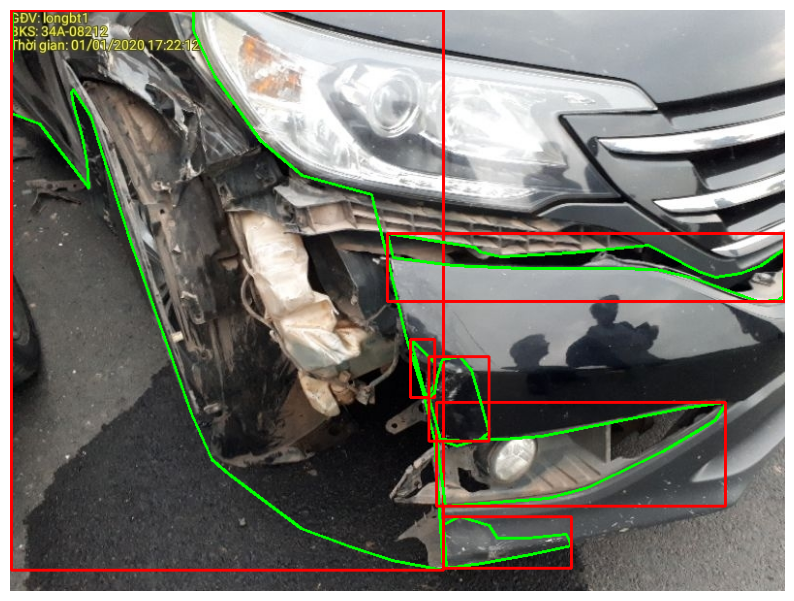

In [92]:
df_example = df[df["name"]=="01012020_172204image853193.jpg"]

image = cv2.imread(image_path)

# IMage is converted to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plotting the boxes and polygons of the image
for index, row in df_example.iterrows():
    # Coordinates of the polygon
    polygon_points = np.array(list(zip(row["all_x"], row["all_y"])), np.int32)
    polygon_points = polygon_points.reshape((-1, 1, 2))
    # Potting the polygon
    cv2.polylines(image_rgb, [polygon_points], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Box 
    x_rect = int(row["x_rect"])
    y_rect = int(row["y_rect"])
    width = int(row["width_rect"])
    height = int(row["height_rect"])
    
    # Poltting the box
    cv2.rectangle(image_rgb, (x_rect, y_rect), (x_rect + width, y_rect + height), (255, 0, 0), 2)

# Showing an example
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")  
plt.show()

## <font color="#62b6cb"> 2 Train set <a name="id2"></a>

### <font color="#62b6cb"> 2.1 Coco format <a name="id21"></a>

For the image augmentation, it will be necessary to have the information in [Coco format](https://auto.gluon.ai/stable/tutorials/multimodal/object_detection/data_preparation/convert_data_to_coco_format.html).


In [93]:
# For being able to apply the augmentation, the json of the training needs to be in coco format and the width and
# height has to be in the dataframe

df["width"] = pd.NA
df["height"] = pd.NA

# name of training images
img_names = os.listdir(train_path_original)

# adding the width and the height of each of the images
for name in img_names:
    img_path = os.path.join(train_path_original, name)
    img = cv2.imread(img_path)

    if img is not None:
        height, width, _ = img.shape
        df.loc[df[df["name"] == name].index, "width" ] = width
        df.loc[df[df["name"] == name].index, "height" ]= height

In [94]:
# Convert to JSON string
coco_format = dataframe_to_coco_format(df, list(df["class"].unique()))
coco_json = json.dumps(coco_format, indent=4)

# Save to a JSON file
with open(os.path.join(train_path_original, train_annotations_json ), "w") as f:
    f.write(coco_json)

df.to_csv("df_width_height.csv")

### <font color="#62b6cb"> 2.2 Breaking down a damage category by severity <a name="id22"></a>

As we want to create car damage budgets, some variables can be break down by severity so it  is possible to give better estimation of the prices to fix the cars. 

In [13]:
# read JSON
with open(os.path.join(train_path_original, train_annotations_json  ), "r") as f:
    coco_data = json.load(f)

In [15]:
data_class = extract_coco_data(coco_data, class_name)

In [33]:
# Extract 10 random images from data_class
np.random.seed(seed)
image_keys = np.array(list(data_class.keys()))
random_images = np.random.choice(image_keys, size=min(20, len(image_keys)), replace=False)

# Plot each of the randomly selected images
for image_name in random_images:
    print(image_name)
    plot_photo_df(train_path_original, image_name, data_class)

NameError: name 'data_class' is not defined

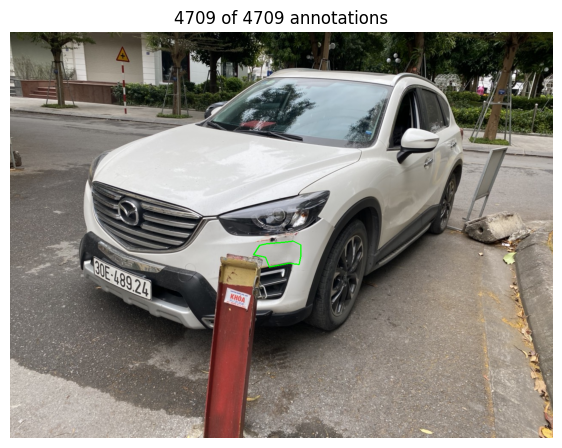

Dropdown(description='Damage:', options=(('Select classification', 0), ('Minor', 1), ('Medium', 2), ('Severe',…

Button(description='Next', style=ButtonStyle())

Output()

Updated JSON saved to .\archive\image\annotation_severity.json


IndexError: list index out of range

IndexError: list index out of range

In [ ]:
if dented_severity_apply_train == 0:
    classify_damage_and_update_json(train_path_original, train_annotations_json , class_name, output_json_severity_path)

In [42]:
if dented_severity_apply_train == 0:  
    # the old json of annotations is moved
    original_file_path = os.path.join(train_path_original, train_annotations_json)
    # the old annotations path  is moved to a new folder
    new_folder_path = os.path.join(train_path_original, folder_old_annnotations_train)
    new_file_path = os.path.join(new_folder_path, train_annotations_json)

    # Check if it exists
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    # Move the file
    os.rename(original_file_path, new_file_path)
    print(f"The old annotations file have been moved {new_file_path}")

    # the new json is moved to the train image file
    new_file_path = os.path.join(train_path_original, train_annotations_json)
    os.rename(output_json_severity_path, new_file_path)

    print(f"The updated annotations file have been moved {new_file_path}")


The old annotations file have been moved .\archive\image\image\old_json_train\annotations.json
The updated annotations file have been moved .\archive\image\image\annotations.json


In [44]:
# Coco json
coco_json_path = os.path.join(train_path_original, train_annotations_json)

# Count elements by categories
category_name_counts = count_category_occurrences(coco_json_path)

# Result
for category_name, count in category_name_counts.items():
    print(f"Category '{category_name}' appears {count} times in the annotations.")

Category 'mis_lost' appears 2370 times in the annotations.
Category 'met_tear' appears 4546 times in the annotations.
Category 'met_scratch' appears 12267 times in the annotations.
Category 'glass_crack' appears 1824 times in the annotations.
Category 'mis_punct' appears 2006 times in the annotations.
Category 'mis_lamp' appears 2324 times in the annotations.
Category 'met_dent_minor' appears 1351 times in the annotations.
Category 'met_dent_medium' appears 1584 times in the annotations.
Category 'met_dent_severe' appears 1774 times in the annotations.


### <font color="#62b6cb"> 2.3 Change classes' ids <a name="id23"></a>

For the mask R-CNN is good that the classes are enumerated sorted (in our case, we have id class 2 and 4 but not 3).

In [45]:
# read JSON
with open(os.path.join(train_path_original, train_annotations_json  ), "r") as f:
    coco_data = json.load(f)

coco_data["categories"]

[{'id': 1, 'name': 'mis_lost', 'supercategory': 'car_damage'},
 {'id': 2, 'name': 'met_tear', 'supercategory': 'car_damage'},
 {'id': 4, 'name': 'met_scratch', 'supercategory': 'car_damage'},
 {'id': 5, 'name': 'glass_crack', 'supercategory': 'car_damage'},
 {'id': 6, 'name': 'mis_punct', 'supercategory': 'car_damage'},
 {'id': 7, 'name': 'mis_lamp', 'supercategory': 'car_damage'},
 {'supercategory': 'met_dent', 'id': 8, 'name': 'met_dent_minor'},
 {'supercategory': 'met_dent', 'id': 9, 'name': 'met_dent_medium'},
 {'supercategory': 'met_dent', 'id': 10, 'name': 'met_dent_severe'}]

In [47]:
# Assign the new categories to coco_data
coco_data["categories"] = new_categories

# Update the category_id in annotations
for annotation in coco_data["annotations"]:
    old_id = annotation["category_id"]
    annotation["category_id"] = old_to_new_ids[old_id]

# Save the updated JSON data
with open(os.path.join(train_path_original, train_annotations_json), "w") as f:
    json.dump(coco_data, f, indent=4)

### <font color="#62b6cb"> 2.4 Split train dataset in train and validation <a name="id24"></a> 

Kaggle gives a file for validation but as we are going  to do tuning over the neural network's parameters, it is needed three sets: test, validation and train. Therefore, the validation images provided by kaggle are going to be our test set and below the train set is split in train and validation and set in a new folder to have everything clearer.

In [48]:
# read coco
with open(os.path.join(train_path_original, train_annotations_json  ), "r") as f:
    coco_data = json.load(f)

# create folder for the split
if not os.path.exists(path_split):
    os.makedirs(path_split)

coco_data.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [49]:
# Keys of coco json
info = coco_data["info"]
licenses = coco_data["licenses"]
images= coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

# split images
random.seed(seed)
random.shuffle(images)
num_val = int(len(images) * val_percentage)
images_val = images[:num_val]
images_train = images[num_val:]

id_images_train =[img['id'] for img in images_train]
id_images_val =[img['id'] for img in images_val]

# Split annotations
annotations_train = [annotation for annotation in annotations if int(annotation['image_id']) in id_images_train]
annotations_val = [annotation for annotation in annotations if int(annotation['image_id']) in id_images_val]

# Create dicts
data_train = {'info': info, 'licenses': licenses,  'categories': categories, 'images': images_train, 'annotations': annotations_train}
data_val = {'info': info, 'licenses': licenses,  'categories': categories, 'images': images_val, 'annotations': annotations_val}


path_train_split =  os.path.join(path_split, folder_train_split)

path_val_split = os.path.join(path_split, folder_val_split)

# create folders in CustomImages
if not os.path.exists( path_train_split):
    os.makedirs(path_train_split )

if not os.path.exists( path_val_split ):
    os.makedirs( path_val_split )
                



with open(os.path.join(path_train_split, train_annotations_json), 'w') as f:
    json.dump(data_train, f, indent=4)

with open(os.path.join(path_val_split, val_annotations_json), 'w') as f:
    json.dump(data_val, f, indent=4)

# Count elements by categories
category_name_counts = count_category_occurrences(os.path.join(path_train_split, train_annotations_json))
print("Train set")
for category_name, count in category_name_counts.items():
    print(f"Category '{category_name}' appears {count} times in the annotations.")

print("\n Val set")
category_name_counts = count_category_occurrences(os.path.join(path_val_split, val_annotations_json))
for category_name, count in category_name_counts.items():
    print(f"Category '{category_name}' appears {count} times in the annotations.")


for img in images_train:
    shutil.copy(os.path.join(train_path_original, img['file_name']), os.path.join(path_train_split, img['file_name']))

for img in images_val:
    shutil.copy(os.path.join(train_path_original, img['file_name']), os.path.join(path_val_split, img['file_name']))


Train set
Category 'mis_lost' appears 1911 times in the annotations.
Category 'met_tear' appears 3611 times in the annotations.
Category 'met_scratch' appears 9862 times in the annotations.
Category 'glass_crack' appears 1428 times in the annotations.
Category 'mis_punct' appears 1635 times in the annotations.
Category 'mis_lamp' appears 1866 times in the annotations.
Category 'met_dent_minor' appears 1080 times in the annotations.
Category 'met_dent_medium' appears 1252 times in the annotations.
Category 'met_dent_severe' appears 1427 times in the annotations.

 Val set
Category 'mis_lost' appears 459 times in the annotations.
Category 'met_tear' appears 935 times in the annotations.
Category 'met_scratch' appears 2405 times in the annotations.
Category 'glass_crack' appears 396 times in the annotations.
Category 'mis_punct' appears 371 times in the annotations.
Category 'mis_lamp' appears 458 times in the annotations.
Category 'met_dent_minor' appears 271 times in the annotations.
Ca

## <font color="#62b6cb"> 3. Test data <a name="id3"></a> 


Now that we have dealed with the train set. We will focus on the test


### <font color="#62b6cb"> 3.1 Read dataset <a name="id31"></a> 

read val.json and convert into annotations COCO format

In [50]:
# Read the JSON file
with open(kaggle_json_val, "r") as file:
    data = json.load(file)

# Prepare the list to store the extracted information
data_list = []

# keys of data are the name of images
# Extract information from the JSON data

for image_name, image_info in data.items():
    for region in image_info["regions"]:
        region_data = {
            "name": image_name,
            "all_x": region["all_x"],
            "all_y": region["all_y"],
            "class": region["class"]
        }
        data_list.append(region_data)

# Create a DataFrame from the extracted information
df_test = pd.DataFrame(data_list)

In [51]:
df_test["class"] = df_test["class"].replace(mapping)


print("Number of elments classification test:",df_test.shape)
print("Number of photos test:", len(df_test["name"].unique()))
print(df_test["class"].value_counts())

Number of elments classification test: (6035, 4)
Number of photos test: 2324
class
met_scratch    2380
met_dent        972
met_tear        963
mis_lamp        458
mis_lost        448
mis_punct       417
glass_crack     397
Name: count, dtype: int64


In [52]:
# The calculation of the boxes is done to each row (each damage)
bounding_boxes = df_test.apply(calculate_bounding_box, axis=1)

# add the boxes to the dataframe
df_test = df_test.join(bounding_boxes)
df_test.head(2)

,name,all_x,all_y,class,x_rect,y_rect,width_rect,height_rect
0,01022020_104459image894113.jpg,"[894, 933, 953, 986, 989, 1009, 1035, 1053, 11...","[729, 784, 773, 725, 690, 675, 672, 634, 641, ...",met_tear,839,565,325,219
1,01022020_104459image894113.jpg,"[355, 332, 325, 324, 306, 270, 245, 244, 332, ...","[735, 729, 708, 660, 641, 637, 616, 595, 591, ...",met_tear,59,577,296,165


### <font color="#62b6cb"> 3.2 Coco format  <a name="id32"></a> 

In [54]:
# For being able to apply the augmentation, the json of the training needs to be in coco format and the width and
# height has to be in the dataframe

df_test["width"] = pd.NA
df_test["height"] = pd.NA

# name of test images
img_names = os.listdir(test_path_original)

# adding the width and the height of each of the images
for name in img_names:
    img_path = os.path.join(test_path_original, name)
    img = cv2.imread(img_path)

    if img is not None:
        height, width, _ = img.shape
        df_test.loc[df_test[df_test["name"] == name].index, "width" ] = width
        df_test.loc[df_test[df_test["name"] == name].index, "height" ]= height

In [55]:
df_test['class'].value_counts()

class
met_scratch    2380
met_dent        972
met_tear        963
mis_lamp        458
mis_lost        448
mis_punct       417
glass_crack     397
Name: count, dtype: int64

In [56]:
# Convert to coco format json
coco_format = dataframe_to_coco_format(df_test, list(df_test["class"].unique()))
coco_json = json.dumps(coco_format, indent=4)

# Save to a JSON file
with open(os.path.join(test_path_original, test_annotations_json ), "w") as f:
    f.write(coco_json)

df_test.to_csv("df_test_width_height.csv")

### <font color="#62b6cb"> 3.3 Breaking down a damage class by severity  <a name="id33"></a> 

In [57]:
# read JSON
with open(os.path.join(test_path_original, test_annotations_json ), "r") as f:
    coco_data = json.load(f)

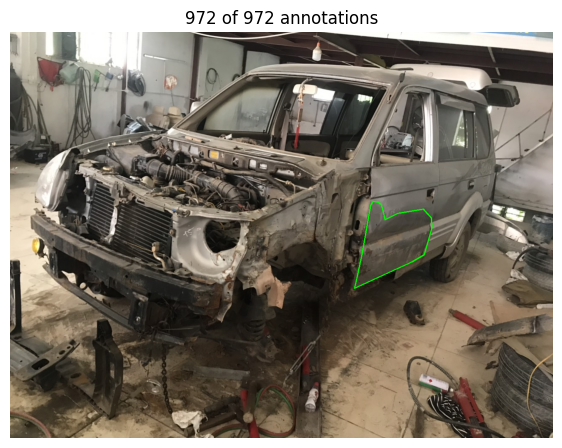

Dropdown(description='Damage:', options=(('Select classification', 0), ('Minor', 1), ('Medium', 2), ('Severe',…

Button(description='Next', style=ButtonStyle())

Output()

Updated JSON saved to .\archive\validation\annotation_severity.json


In [ ]:
if dented_severity_apply_test == 0:
    classify_damage_and_update_json(test_path_original, test_annotations_json , class_name, output_json_severity_path_test)

In [61]:
# the old json of annotations is moved
if dented_severity_apply_test == 0:
    original_file_path = os.path.join(test_path_original, test_annotations_json)
    # the old annotations path  is moved to a new folder
    new_folder_path = os.path.join(test_path_original, folder_old_annnotations_test)
    new_file_path = os.path.join(new_folder_path, test_annotations_json)
    # Check if it exists
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    # Move the file
    os.rename(original_file_path, new_file_path)

    print(f"The file have been moved {new_file_path}")

    # the new json is moved to the test image file
    new_file_path = os.path.join(test_path_original, test_annotations_json)

    # Move the file
    os.rename(output_json_severity_path_test, new_file_path)

    print(f"The file have been moved {new_file_path}")

    dented_severity_apply_test = 1

The file have been moved .\archive\validation\validation\old_json_test\annotations.json
The file have been moved .\archive\validation\validation\annotations.json


In [62]:
# Coco json
coco_json_path = os.path.join(test_path_original, test_annotations_json)

# Count elements by categories
category_name_counts = count_category_occurrences(coco_json_path)

# Result
for category_name, count in category_name_counts.items():
    print(f"Category '{category_name}' appears {count} times in the annotations.")

Category 'met_tear' appears 963 times in the annotations.
Category 'met_scratch' appears 2380 times in the annotations.
Category 'glass_crack' appears 397 times in the annotations.
Category 'mis_lost' appears 448 times in the annotations.
Category 'mis_punct' appears 417 times in the annotations.
Category 'mis_lamp' appears 458 times in the annotations.
Category 'met_dent_minor' appears 257 times in the annotations.
Category 'met_dent_medium' appears 344 times in the annotations.
Category 'met_dent_severe' appears 371 times in the annotations.


### <font color="#62b6cb"> 3.4 Change classes' ids  <a name="id34"></a> 



The id of the categories is not in the same order that in the train json so we change it so everything is correct

In [63]:
# categories train
new_categories

[{'id': 1, 'name': 'mis_lost', 'supercategory': 'car_damage'},
 {'id': 2, 'name': 'met_tear', 'supercategory': 'car_damage'},
 {'id': 3, 'name': 'met_scratch', 'supercategory': 'car_damage'},
 {'id': 4, 'name': 'glass_crack', 'supercategory': 'car_damage'},
 {'id': 5, 'name': 'mis_punct', 'supercategory': 'car_damage'},
 {'id': 6, 'name': 'mis_lamp', 'supercategory': 'car_damage'},
 {'id': 7, 'name': 'met_dent_minor', 'supercategory': 'met_dent'},
 {'id': 8, 'name': 'met_dent_medium', 'supercategory': 'met_dent'},
 {'id': 9, 'name': 'met_dent_severe', 'supercategory': 'met_dent'}]

In [65]:
with open(os.path.join(test_path_original, test_annotations_json  ), "r") as f:
    coco_data = json.load(f)

# categories test
coco_data["categories"]

[{'id': 1, 'name': 'met_tear', 'supercategory': 'car_damage'},
 {'id': 2, 'name': 'met_scratch', 'supercategory': 'car_damage'},
 {'id': 3, 'name': 'glass_crack', 'supercategory': 'car_damage'},
 {'id': 4, 'name': 'mis_lost', 'supercategory': 'car_damage'},
 {'id': 5, 'name': 'mis_punct', 'supercategory': 'car_damage'},
 {'id': 7, 'name': 'mis_lamp', 'supercategory': 'car_damage'},
 {'supercategory': 'met_dent', 'id': 8, 'name': 'met_dent_minor'},
 {'supercategory': 'met_dent', 'id': 9, 'name': 'met_dent_medium'},
 {'supercategory': 'met_dent', 'id': 10, 'name': 'met_dent_severe'}]

In [66]:
# Create a mapping from old category IDs to new category IDs
old_to_new_id_map = {
    4: 1,  # mis_lost
    1: 2,  # met_tear
    2: 3,  # met_scratch
    3: 4,  # glass_crack
    5: 5,  # mis_punct
    7: 6,  # mis_lamp
    8: 7,  # met_dent_minor
    9: 8,  # met_dent_medium
    10: 9  # met_dent_severe
}

# Update the categories in the COCO data
coco_data["categories"] = new_categories

# Update the annotations with the new category IDs
for annotation in coco_data["annotations"]:
    old_id = annotation["category_id"]
    if old_id in old_to_new_id_map:
        annotation["category_id"] = old_to_new_id_map[old_id]

# Save the updated JSON file
with open(os.path.join(test_path_original, test_annotations_json), "w") as f:
    json.dump(coco_data, f, indent=4)

print(f"Updated JSON saved to {os.path.join(test_path_original, test_annotations_json)}")

Updated JSON saved to .\archive\validation\validation\annotations.json


### <font color="#62b6cb"> 3.5 Test folder ids  <a name="id35"></a> 

The data and annotations are copy in a test folder in CustomImages

In [75]:
os.path.join(path_test_split ,test_annotations_json)

'.\\CustomImages\\test\\annotations.json'

In [77]:
path_test_split = os.path.join(path_split, folder_test_split)
if not os.path.exists( path_test_split ):
    os.makedirs( path_test_split )

# Read the COCO format JSON file
with open(os.path.join(test_path_original, test_annotations_json  ), "r") as f:
    coco_data = json.load(f)

# Copy the JSON file to the destination directory
shutil.copy2(os.path.join(test_path_original, test_annotations_json), os.path.join(path_test_split, test_annotations_json))

# Create a set of all image filenames in the JSON file
image_filenames = {image["file_name"] for image in coco_data["images"]}

# Copy each image file to the destination directory
for image_filename in image_filenames:
    src_image_path = os.path.join(test_path_original, image_filename)
    dest_image_path = os.path.join(path_test_split, image_filename)
    
    # Check if the image file exists in the source directory before copying
    if os.path.exists(src_image_path):
        shutil.copy2(src_image_path, dest_image_path)
    else:
        print(f"Warning: {src_image_path} does not exist and will not be copied.")

print(f"All specified images and {test_annotations_json} copied to {path_test_split}.")

All specified images and annotations.json copied to .\CustomImages\test.


In [78]:
print("\n Test set")
category_name_counts = count_category_occurrences(os.path.join(path_test_split, test_annotations_json))
for category_name, count in category_name_counts.items():
    print(f"Category '{category_name}' appears {count} times in the annotations.")




 Test set
Category 'mis_lost' appears 448 times in the annotations.
Category 'met_tear' appears 963 times in the annotations.
Category 'met_scratch' appears 2380 times in the annotations.
Category 'glass_crack' appears 397 times in the annotations.
Category 'mis_punct' appears 417 times in the annotations.
Category 'mis_lamp' appears 458 times in the annotations.
Category 'met_dent_minor' appears 257 times in the annotations.
Category 'met_dent_medium' appears 344 times in the annotations.
Category 'met_dent_severe' appears 371 times in the annotations.
